# Sea Ice Concentration

This a first pass of the information we might be interested in for the MIZ 2023 voyage and resulting research from a sea ice concentration dataset.

In [1]:
#directory paths
_work_dir='/g/data/jk72/as2285/miz/'
_data_dir='/g/data/jk72/MIZ/'

In [7]:
#some constants
CLIMAT_DATES=[1981,2010]
EAST_ANT_LONS=[71,160] #longitudes for east Antartica (easterly)
YEAR=2012
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
#TO-DO - move file paths here?

In [3]:
#useful py libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as ticker

In [4]:
# import local functions
import sys
sys.path.append(_work_dir)
from utils.sea_ice_conc import sea_ice_conc

In [5]:
%matplotlib inline

In [8]:
#start cluster
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=4, memory='11.75GB', walltime="2:00:00")
client = Client(cluster)
cluster.scale(cores=4)

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.09.1/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46025 instead
  warnings.warn(


In [9]:
! sleep 30

In [10]:
!squeue -u as2285

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
             39936      main dask-wor   as2285  R       0:38      1 ood-n11
             39901       vdi sys/dash   as2285  R    1:30:08      1 ood-vn27


In [11]:
print(cluster)

SLURMCluster(1dce9dd3, 'tcp://10.0.128.155:36749', workers=4, threads=4, memory=10.96 GiB)


In [12]:
print(client)

<Client: 'tcp://10.0.128.155:36749' processes=4 threads=4, memory=10.96 GiB>


# Plotting functions

Some functions to make plotting easier

In [13]:
def plot_climat(ds):
    """
    starting with an xarray dataset with the fields ave and st_dev seperated by month, 
    produce a plot with a 95% confidence interval and mean
    
    
    
    example use:
        plt.figure(figsize=[8,8])
        plt.subplot()
        plot_climat(xarray_dataset)
        plt.show()
    
    """
    
    #start in december, go through one whole year and then end in jan
    
    month_nums=np.array([ds.month[0].values-0.5,*(ds.month+0.5).values,ds.month[-1].values+1.5])
    aves=np.array([ds.ave[-1].values,*ds.ave.values,ds.ave[0].values])
    st_devs=np.array([ds.st_dev[-1].values,*ds.st_dev.values,ds.st_dev[0].values])
    
    plt.plot(
        month_nums,
        aves, 
        color='black',
        label='Mean'
    )

    plt.fill_between(
        month_nums,
        aves-2*st_devs, 
        aves+2*st_devs,
        color='lightgrey',
        label='95% CI'
    )

    plt.xticks(
        ticks=[1,2,3,4,5,6,7,8,9,10,11,12],
        labels=months
    )
    
    plt.xlim(1,13)

    plt.ylabel('km\u00b2')
    plt.legend()
 

In [14]:
def plot_year(da, year):
    """
    starting with an xarray dataarray timeseries, and a specified year, 
    plot the data as a monthly timeseries
    
    example use:
        plt.figure(figsize=[8,8])
        plt.subplot()
        plot_year(xarray_dataArray)
        plt.show()
    
    """
    
    #TO_DO: extent with data from previous December and following Jan?
    
    to_plot_da=da.where(da.time.dt.year==int(year), drop=True)
    
    #if monthly, then plot ticks are middle of the month
    if len(to_plot_da.time)==to_plot_da.time.dt.month.values[-1]: #number of months equals the month of the last timestamp
        time_ticks=to_plot_da.time.dt.month+0.5
    else:
        #daily, plot ticks are month + fraction of month for that day
        time_ticks=to_plot_da.time.dt.month+(to_plot_da.time.dt.day/to_plot_da.time.dt.daysinmonth)
    
    plt.plot(
        time_ticks,
        to_plot_da,
        color='purple',
        dashes=(4,3),
        label=str(int(year))
    )
    
    plt.xticks(
        ticks=[1,2,3,4,5,6,7,8,9,10,11,12],
        labels=months
    )
    
    plt.xlim(1,13)
    
    plt.legend()

# Open the dataset

Using the NSIDC Sea Ice Concentration gridded data set, historical monthly averages of sea ice concentration

In [15]:
hist_cdr_xr = xr.open_dataset(
    f'{_data_dir}/NSIDC/G02202_V4/seaice_conc_monthly_sh_197811_202112_v04r00.nc',
    #chunks='auto'
)

hist_cdr_xr = hist_cdr_xr.swap_dims({
    'tdim':'time', 
    'x':'xgrid',
    'y':'ygrid'
                                    }).rename_vars({'cdr_seaice_conc_monthly':'cdr_seaice_conc'})

We are going to compare this to the current (2022) conditions:

In [16]:
daily_files = ! ls -d {_data_dir}/NSIDC/G10016_V2/daily/*.nc

In [17]:
daily_da=xr.concat(
    [
        xr.open_dataset(iFile,
                        #chunks='auto'
                       ).swap_dims({'tdim':'time', 
        'x':'xgrid',
        'y':'ygrid'}) for iFile in daily_files
    ], 
    'time'
)

#we could resample to monlthy, but daily data actually works fine
current_cdr_xr=daily_da#.resample(time='M',label='left', loffset='1D').mean('time')

In [18]:
daily_da

<xarray.Dataset>
Dimensions:                      (time: 144, ygrid: 332, xgrid: 316)
Coordinates:
  * time                         (time) datetime64[ns] 2022-01-01 ... 2022-05-24
  * xgrid                        (xgrid) float32 -3.938e+06 ... 3.938e+06
  * ygrid                        (ygrid) float32 4.338e+06 ... -3.938e+06
Data variables:
    cdr_seaice_conc              (time, ygrid, xgrid) float32 0.0 0.0 ... 0.0
    nsidc_bt_seaice_conc         (time, ygrid, xgrid) float32 0.0 0.0 ... 0.0
    nsidc_nt_seaice_conc         (time, ygrid, xgrid) float32 0.0 0.0 ... 0.0
    projection                   (time) |S1 b'' b'' b'' b'' ... b'' b'' b'' b''
    qa_of_cdr_seaice_conc        (time, ygrid, xgrid) float32 16.0 16.0 ... 16.0
    spatial_interpolation_flag   (time, ygrid, xgrid) float32 nan nan ... nan
    stdev_of_cdr_seaice_conc     (time, ygrid, xgrid) float32 nan nan ... nan
    temporal_interpolation_flag  (time, ygrid, xgrid) float32 nan nan ... nan
Attributes: (12/40)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc
    ...                        ...
    source:                    Generated from NSIDC0080
    platform:                  DMSP 5D-3/F18 > Defense Meteorological Satelli...
    sensor:                    SSMI/S > Special Sensor Microwave Imager/Sounder
    date_created:              2022-01-07T10:51:36Z
    time_coverage_start:       2022-01-01T00:00:00Z
    time_coverage_end:         2022-01-01T23:59:59Z

Put the historical monthly data, and the near real time data in one array:

In [19]:
# If the two datasets have gone out of sync, raise an error.
# This would be amiguous, the historical (released data) and the current (near-real time data) 
# are covering the same times and we don't know which one to use.
if hist_cdr_xr.time_coverage_end>current_cdr_xr.time_coverage_start:
    raise RuntimeError("Times in historical data overlap with near-real time data")

cdr_ds=xr.concat(
    [hist_cdr_xr.cdr_seaice_conc, current_cdr_xr.cdr_seaice_conc], #this is the only data field we use
    'time'
)

#merge the long and lat back in for convenience
cdr_xr=xr.merge(
    [
        cdr_ds,
        hist_cdr_xr.longitude,
        hist_cdr_xr.latitude]
)

cdr_xr

<xarray.Dataset>
Dimensions:          (time: 662, xgrid: 316, ygrid: 332)
Coordinates:
  * time             (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2022-05-24
  * xgrid            (xgrid) float32 -3.938e+06 -3.912e+06 ... 3.938e+06
  * ygrid            (ygrid) float32 4.338e+06 4.312e+06 ... -3.938e+06
Data variables:
    cdr_seaice_conc  (time, ygrid, xgrid) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    longitude        (ygrid, xgrid) float32 ...
    latitude         (ygrid, xgrid) float32 ...
Attributes:
    long_name:            NOAA/NSIDC Climate Data Record of Passive Microwave...
    standard_name:        sea_ice_area_fraction
    units:                1
    flag_values:          [251 252 253 254 255]
    flag_meanings:        pole_hole lakes coastal land_mask missing_data
    datum:                +ellps=urn:ogc:def:crs:EPSG::4326
    grid_mapping:         projection
    reference:            https://nsidc.org/data/g02202/versions/4/
    ancillary_variables:  stdev_of_cdr_seaice_conc_monthly qa_of_cdr_seaice_c...
    valid_range:          [  0 100]
    cell_methods:         tdim: mean

Annoyingly, the area of each grid cell is provided seperately:

In [20]:
datFile=open('/g/data/jk72/MIZ/NSIDC/pss25area_v3.dat', 'rb')
#pss25area_v3.dat: 316 columns x 332 rows
areasDmNd=np.fromfile(datFile, dtype=np.int32).reshape([332,316])

#Divide by 1000 to get km2
areasKmNd=areasDmNd/1000

# Climatologies for sea ice extent and area

Climatologies for extent and area of sea ice. 

Extent is the total area of the ocean where the concetration of sea ice is estimated to be greater than 15%

Area is the area of the sea ice only (smaller than extent). Concentrations less than 15% were discarded prior to calculating this area

In [21]:
ant_conc=sea_ice_conc(cdr_xr.cdr_seaice_conc, areasKmNd ) #local class

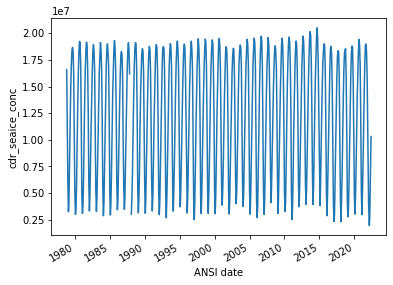

In [22]:
ant_conc.calc_extent()
ant_conc.extent_da.plot(); #plot for sanity showing gap in data
#CDR has a gap in the data from 03 December 1987 through 12 January 1988 (ref: https://nsidc.org/data/g02202)

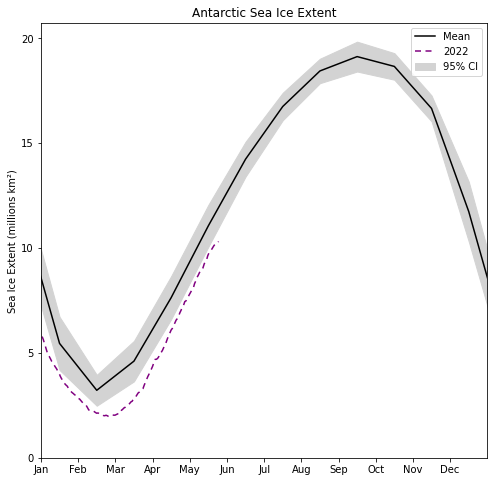

In [23]:
plt.figure(figsize=[8,8])
plt.subplot()

plot_climat(ant_conc.extent_climat_ds)

plot_year(ant_conc.extent_da, 2022)

plt.yticks(
    ticks=[0, 5e6, 10e6, 15e6, 20e6],
    labels=['0','5','10','15','20']
)
plt.ylabel('Sea Ice Extent (millions km\u00b2)')

plt.title('Antarctic Sea Ice Extent')
plt.legend()
plt.savefig(f'{_work_dir}figures/nsidc_sea_ice_extent_2022.svg')

In [24]:
ant_conc.calc_area()

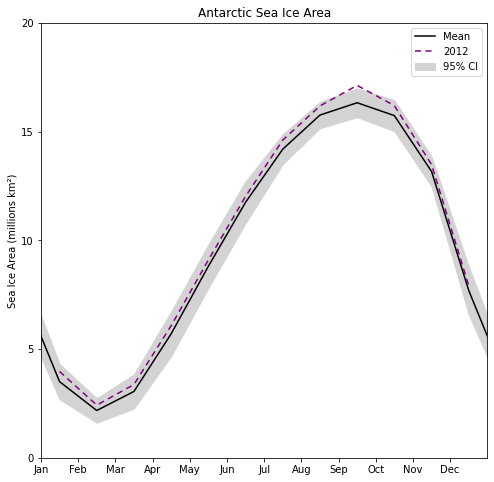

In [25]:
plt.figure(figsize=[8,8])

plt.subplot()

plot_climat(ant_conc.area_climat_ds)

plot_year(ant_conc.area_da, YEAR)

plt.yticks(
    ticks=[0, 5e6, 10e6, 15e6, 20e6],
    labels=['0','5','10','15','20']
)
plt.ylabel('Sea Ice Area (millions km\u00b2)')

plt.title('Antarctic Sea Ice Area')
plt.show()

# distribution of sea ice

Monthly mean concentrations (1981-2010)

In [26]:
ant_conc.calc_gridded_anoms()

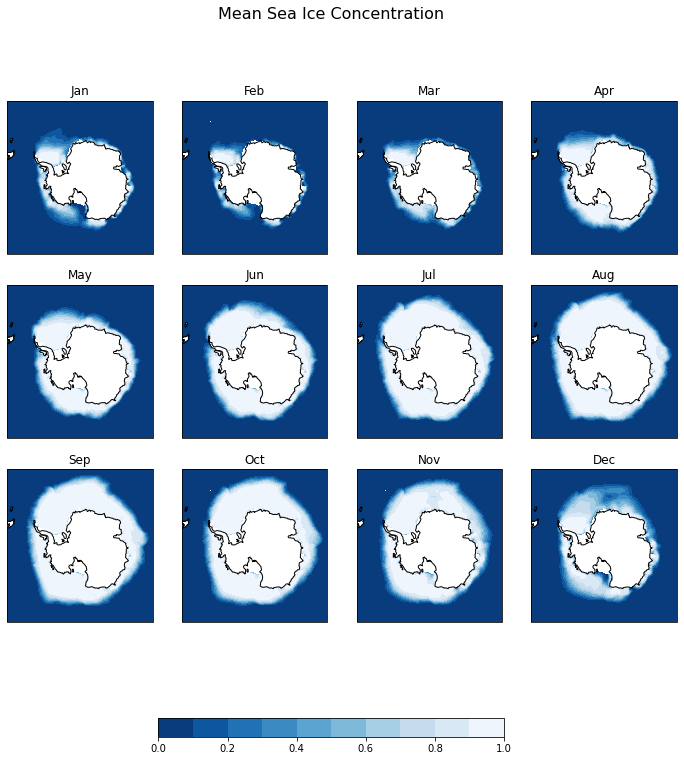

In [27]:
plt.figure(figsize=(12,13))
plt.suptitle('Mean Sea Ice Concentration', fontsize=16)

for iMonth in ant_conc.conc_climat_ds.month.values:
    
    ax = plt.subplot(4,4,iMonth,projection=ccrs.SouthPolarStereo())
    
    toPlot=ant_conc.conc_climat_ds.ave.sel(month=iMonth)
    
    plt.contourf(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        levels=np.arange(0,1.04,.1),
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='Blues_r',
        )

    #gl = ax.gridlines(
    #    draw_labels=False, linewidth=2, color='gray', alpha=0.5, linestyle='--'
    #)

    ax.coastlines()
    plt.title(months[iMonth-1])
    
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.3,0.2,0.4,0.02]))
plt.show()

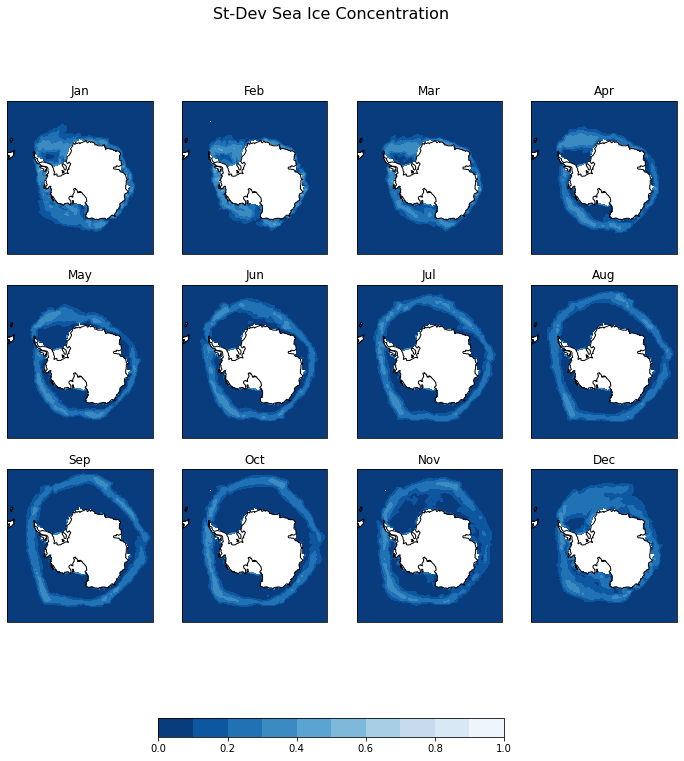

In [53]:
plt.figure(figsize=(12,13))
plt.suptitle('St-Dev Sea Ice Concentration', fontsize=16)

for iMonth in ant_conc.conc_climat_ds.month.values:
    
    ax = plt.subplot(4,4,iMonth,projection=ccrs.SouthPolarStereo())
    
    toPlot=ant_conc.conc_climat_ds.st_dev.sel(month=iMonth)
    
    plt.contourf(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        levels=np.arange(0,1.04,.1),
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='Blues_r',
        )

    #gl = ax.gridlines(
    #    draw_labels=False, linewidth=2, color='gray', alpha=0.5, linestyle='--'
    #)

    ax.coastlines()
    plt.title(months[iMonth-1])
    
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.3,0.2,0.4,0.02]))
plt.show()

# anomalies in distribution of sea ice

In [28]:
# reduce resolution to speed up contour lines?
coarse_conc_da=ant_conc.da

coarse_anoms_da=ant_conc.anoms_da#.coarsen(x=4).mean().coarsen(y=4).mean()

course_climat_ds=ant_conc.conc_climat_ds#.coarsen(x=4).mean().coarsen(y=4).mean()

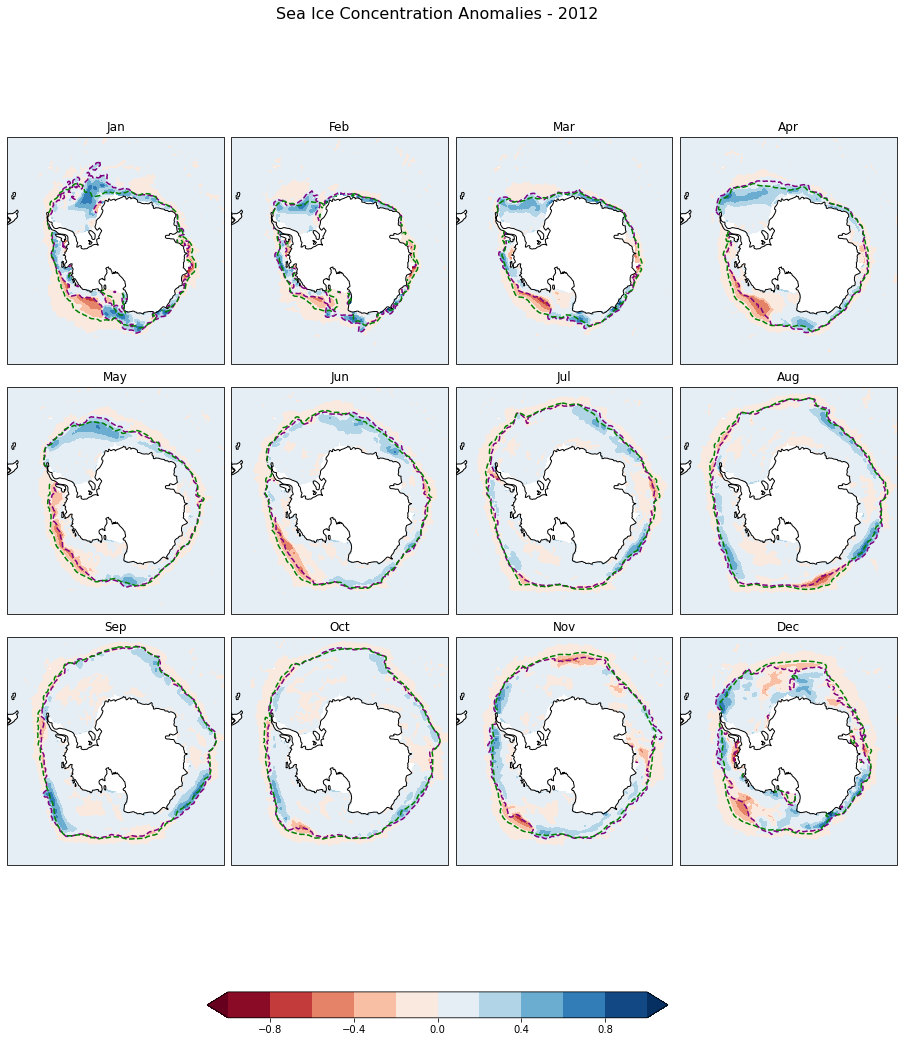

In [29]:
#very messy months in current year
months_in_current_year=ant_conc.anoms_da.where(ant_conc.anoms_da.time.dt.year==YEAR, drop=True).time.dt.month.values 

plt.figure(figsize=(16,18))
plt.suptitle('Sea Ice Concentration Anomalies - ' + str(YEAR), fontsize=16)

for iMonth in months_in_current_year:
    
    ax = plt.subplot(4,4,iMonth,projection=ccrs.SouthPolarStereo())
    
    #sea ice extent climatology
    toPlot=coarse_conc_da.sel(time=np.datetime64(str(YEAR)+"-"+"%02d" %iMonth))
    plt.contour(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        levels=[.15],
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        colors='purple',
        linewidths=1.5,
        linestyles='dashed'
    )
    
    #sea ice extent for YEAR
    toPlot=course_climat_ds.ave.sel(month=iMonth)
    plt.contour(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        levels=[.15],
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        colors='green',
        linewidths=1.5,
        linestyles='dashed'
    )
    
    #sea ice anoms
    toPlot=coarse_anoms_da.sel(time=np.datetime64(str(YEAR)+"-"+"%02d" %iMonth))
    plt.contourf(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        levels=np.arange(-1,1.04,.2),
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='RdBu',
        extend='both'
        )
    
    #gl = ax.gridlines(
    #    draw_labels=False, linewidth=2, color='gray', alpha=0.5, linestyle='--'
    #)

    ax.coastlines()
    plt.title(months[iMonth-1])

plt.subplots_adjust(hspace=0.1,wspace=0.02)
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.3,0.2,0.4,0.02]))
plt.show()

Example of one month to make a nice plot:

In [30]:
def plotStipling(da,criteria,ax):
    """
    
    
    
    """
    
    #try:
        #if len(da.model.values)<2:
        #    raise EnvironmentError("Nothing to stiple, there needs to be at least 2 models")
    #except:
        #raise EnvironmentError("Does this dataarray have a model dimension?")
    #Error checking should probably check there are only three dimensions.
    
    lessThan=(da<-criteria)
    greatThan=(da>criteria)
    
    #Area to add stipling 
    combined=(
        lessThan|greatThan
    )

    #plot it
    plt.sca(ax)
    
    c=plt.pcolor(
        combined.xgrid,
        combined.ygrid,
        np.ma.masked_equal(combined,0),
        hatch='.',
        alpha=0,
        shading='auto',
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
    )
    
    return combined


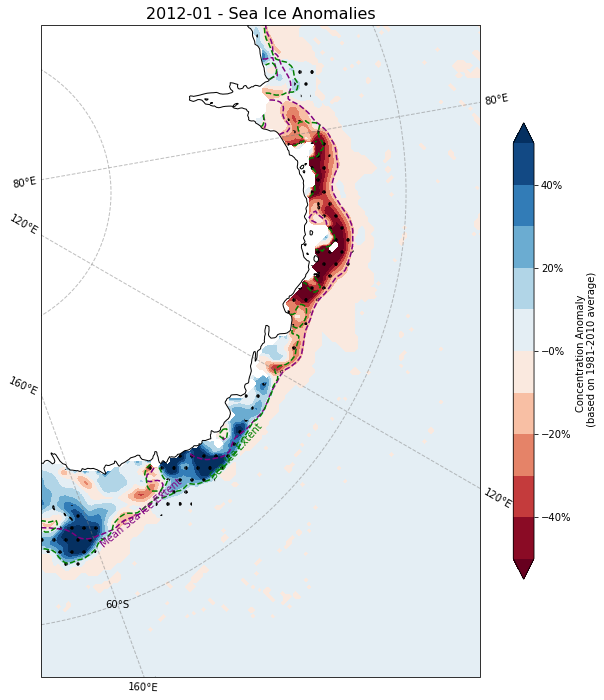

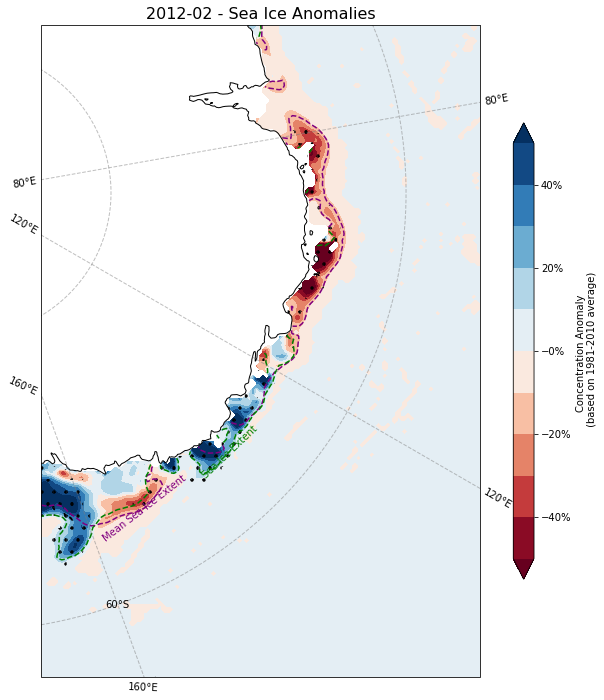

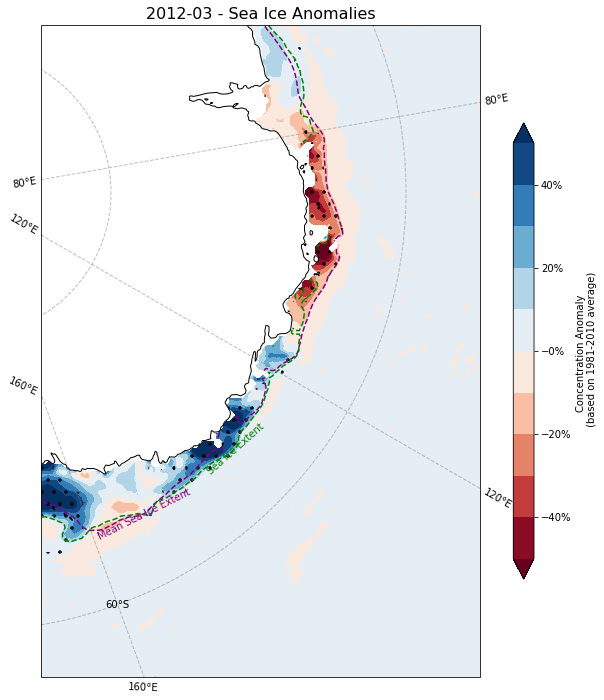

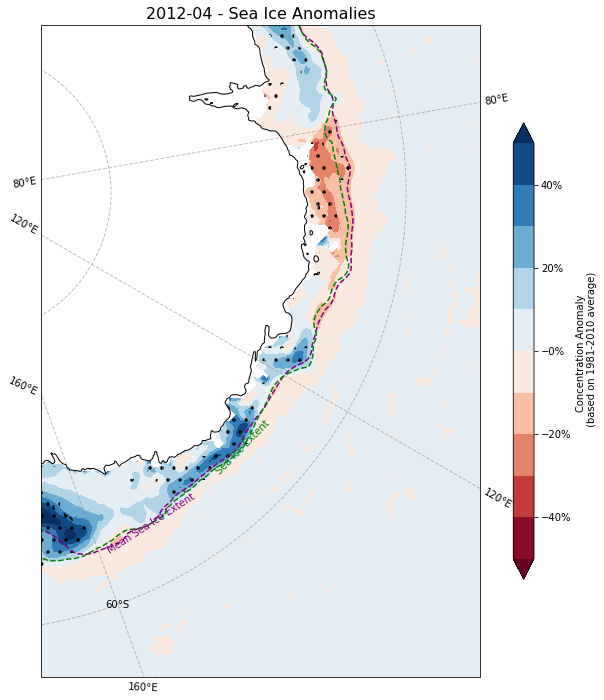

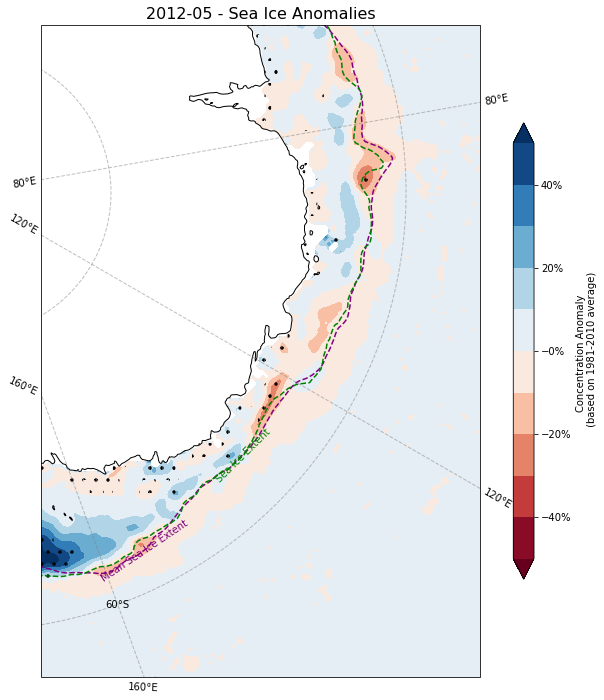

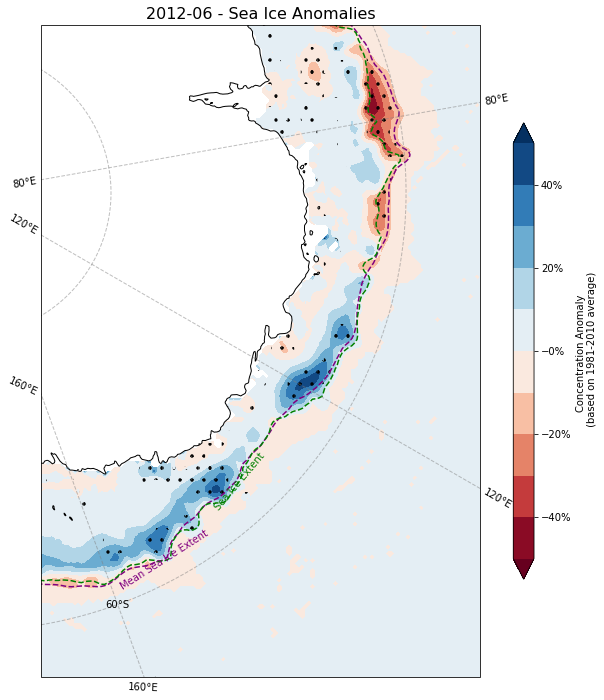

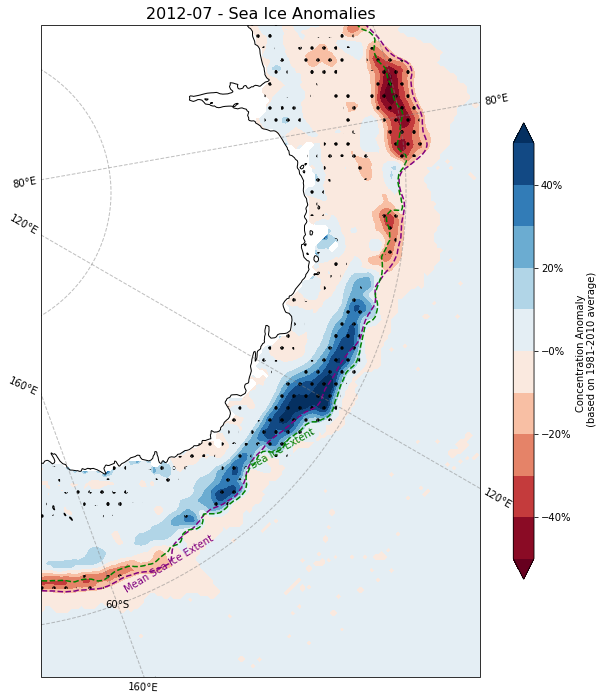

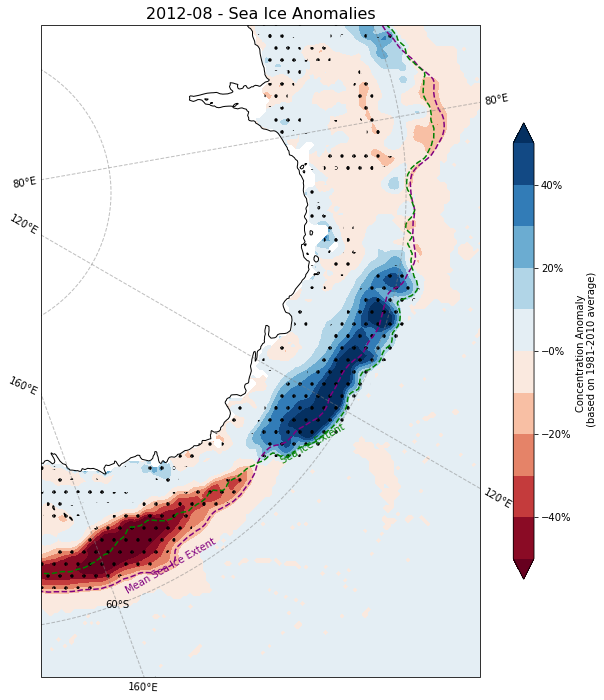

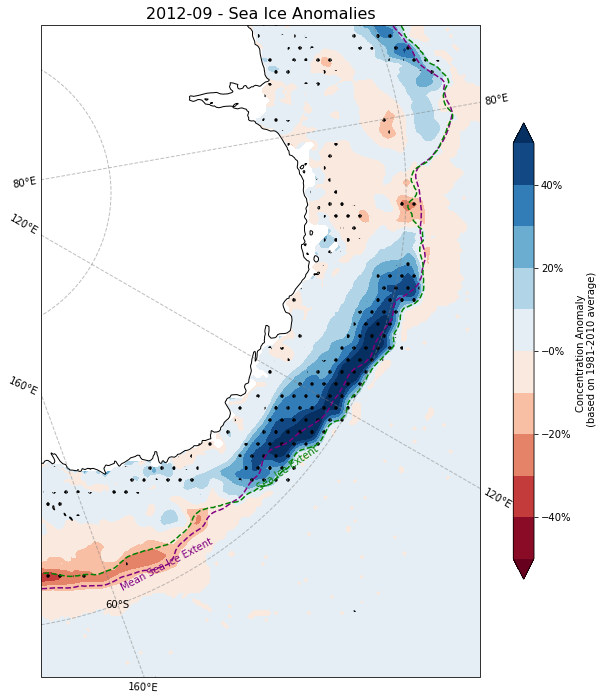

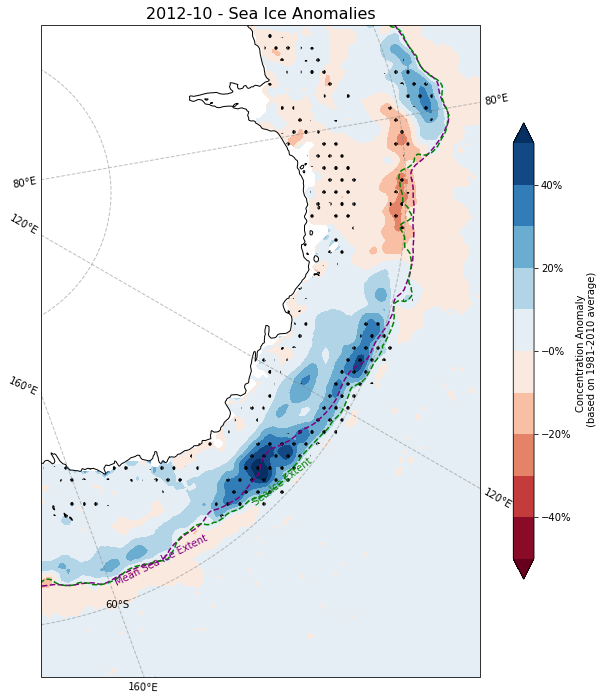

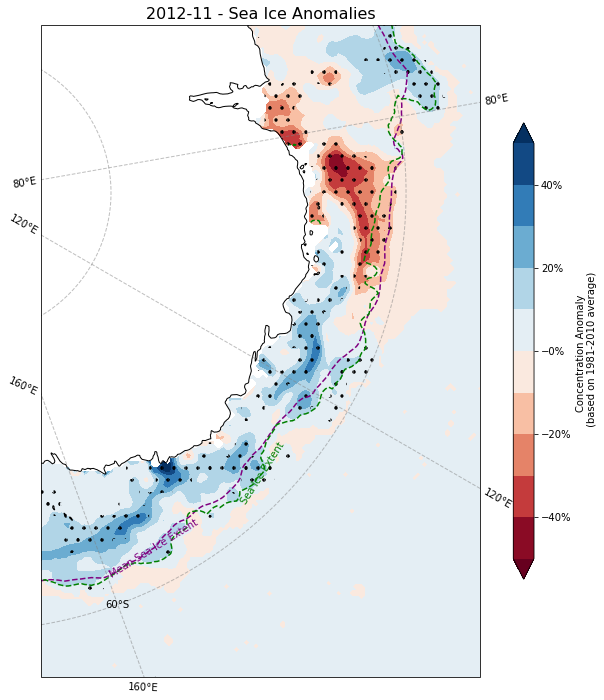

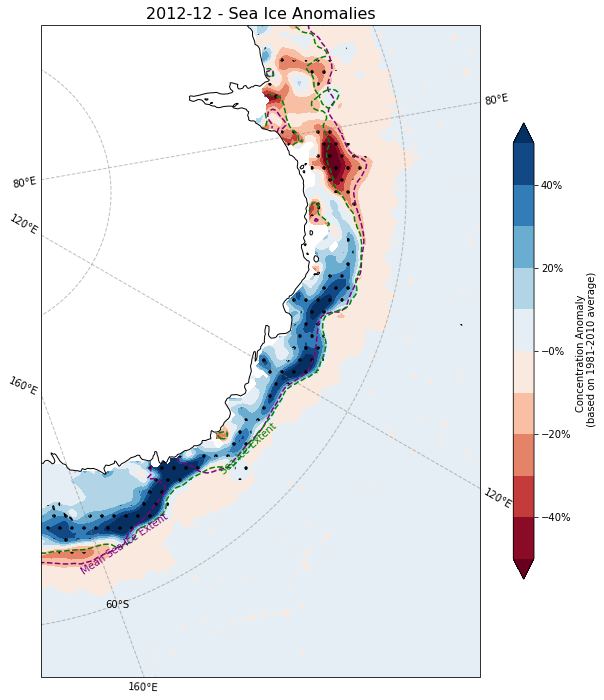

In [32]:
for MONTH in np.arange(1,13,1):

    plt.figure(figsize=(12,12))
    ax=plt.subplot(projection=ccrs.SouthPolarStereo())


    #sea ice extent climatology for month
    toPlot=course_climat_ds.ave.sel(month=MONTH)
    cs1=plt.contour(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        levels=[.15],
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        colors='purple',
        linewidths=1.5,
        linestyles='dashed',
    )

    #sea ice extent for YEAR + month
    toPlot=coarse_conc_da.sel(time=np.datetime64(f'{YEAR:04.0f}-{MONTH:02.0f}'))
    cs2=plt.contour(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        levels=[.15],
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        colors='green',
        linewidths=1.5,
        linestyles='dashed'
    )

    #sea ice conc anoms
    toPlot_anoms=coarse_anoms_da.sel(time=np.datetime64(f'{YEAR:04.0f}-{MONTH:02.0f}'))
    plt.contourf(
        toPlot_anoms.xgrid, 
        toPlot_anoms.ygrid, 
        toPlot_anoms.values,
        levels=np.arange(-0.5,0.51,.1),
        extend='both',
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='RdBu',
    )

    plt.colorbar(
        shrink=0.7, 
        #ticks=np.arange(-0.45,0.46,.1),
        format=ticker.PercentFormatter(xmax=1),
        label='Concentration Anomaly \n (based on 1981-2010 average)'
    )

    plotStipling(
        toPlot_anoms,
        course_climat_ds.st_dev.sel(month=MONTH),
        ax
    )

    gl = ax.gridlines(
        draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
        xlocs=[80,120,160], ylocs=[-60,-80]
    )

    ax.coastlines()

    plt.title((f'{YEAR:04.0f}-{MONTH:02.0f} - Sea Ice Anomalies'), fontsize=16)
    ax.set_extent([EAST_ANT_LONS[0], EAST_ANT_LONS[1], -75, -55], crs=ccrs.PlateCarree())
    cs1.clabel(fmt='Mean Sea Ice Extent', 
        manual=[(2000000,-4000000)],
         inline=False)
    cs2.clabel(fmt='Sea Ice Extent', 
        manual=[(3000000,-3000000)],
         inline=False)

    plt.show()
    #plt.savefig(f'{_work_dir}figures/nsidc_sea_ice_conc_anoms_sept_2021_ea.svg',bbox_inches='tight')

# Repeat for east Antarctic only

In [33]:
EAST_ANT_LONS

[71, 160]

In [34]:
e_ant_conc=sea_ice_conc(
    cdr_xr.where(
        (cdr_xr.longitude>EAST_ANT_LONS[0])
        *(cdr_xr.longitude<EAST_ANT_LONS[1])
    ).cdr_seaice_conc, 
    areasKmNd
)

In [35]:
e_ant_conc.calc_extent()

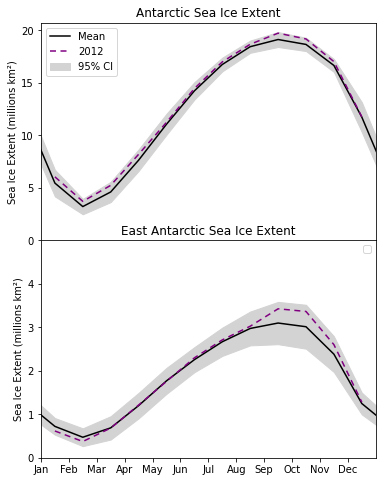

In [36]:
plt.figure(figsize=[6,8])
plt.subplot(2,1,1)

plot_climat(ant_conc.extent_climat_ds)

plot_year(ant_conc.extent_da, YEAR)

plt.yticks(
    ticks=[0, 5e6, 10e6, 15e6, 20e6],
    labels=['0','5','10','15','20']
)
plt.xticks(ticks=[5], labels=['_'])
plt.ylabel('Sea Ice Extent (millions km\u00b2)')

plt.title('Antarctic Sea Ice Extent')

plt.subplot(2,1,2)

plot_climat(e_ant_conc.extent_climat_ds)

plot_year(e_ant_conc.extent_da, YEAR)

plt.yticks(
    ticks=[0, 1e6, 2e6, 3e6, 4e6],
    labels=['0','1','2','3','4']
)
plt.ylim([0,5e6])

plt.title('East Antarctic Sea Ice Extent')
plt.ylabel('Sea Ice Extent (millions km\u00b2)')
plt.legend([])

plt.subplots_adjust(hspace=.0)

plt.savefig(f'{_work_dir}figures/nsidc_sea_ice_extent_2022_ea.svg', bbox_inches='tight')

In [37]:
e_ant_conc.calc_area()

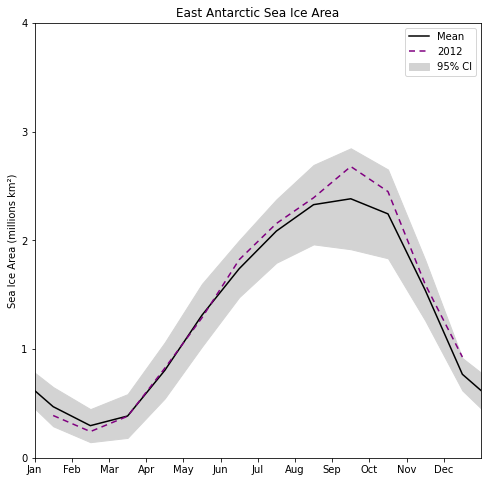

In [38]:
plt.figure(figsize=[8,8])

plt.subplot()

plot_climat(e_ant_conc.area_climat_ds)

plot_year(e_ant_conc.area_da, YEAR)

plt.yticks(
    ticks=[0, 1e6, 2e6, 3e6, 4e6],
    labels=['0','1','2','3','4']
)

plt.title('East Antarctic Sea Ice Area')
plt.ylabel('Sea Ice Area (millions km\u00b2)')

plt.show()

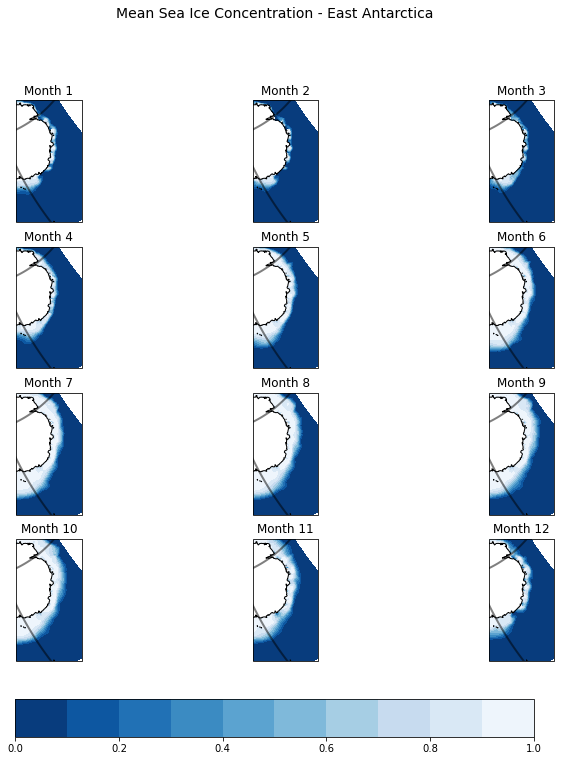

In [39]:
plt.figure(figsize=(12,13))
plt.suptitle('Mean Sea Ice Concentration - East Antarctica', fontsize=14)


for iMonth in ant_conc.conc_climat_ds.month.values:
    
    ax = plt.subplot(
        5,3,iMonth,
        projection=ccrs.Stereographic()#central_longitude=(EAST_ANT_LONS[0]+EAST_ANT_LONS[1])/2)
        )
    
    ax.set_extent([EAST_ANT_LONS[0], EAST_ANT_LONS[1], -75, -55], crs=ccrs.PlateCarree())

    
    toPlot=ant_conc.conc_climat_ds.ave.sel(month=iMonth)
    
    plt.contourf(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        levels=np.arange(0,1.04,.1),
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='Blues_r',
        )

    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), xlocs=[EAST_ANT_LONS[0], EAST_ANT_LONS[1]], ylocs=[],
        draw_labels=False, linewidth=2, color='black', alpha=0.5, #linestyle='--'
    )

    ax.coastlines()
    plt.title('Month ' + str(iMonth))
    
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.2,0.2,0.6,0.04]))
plt.show()

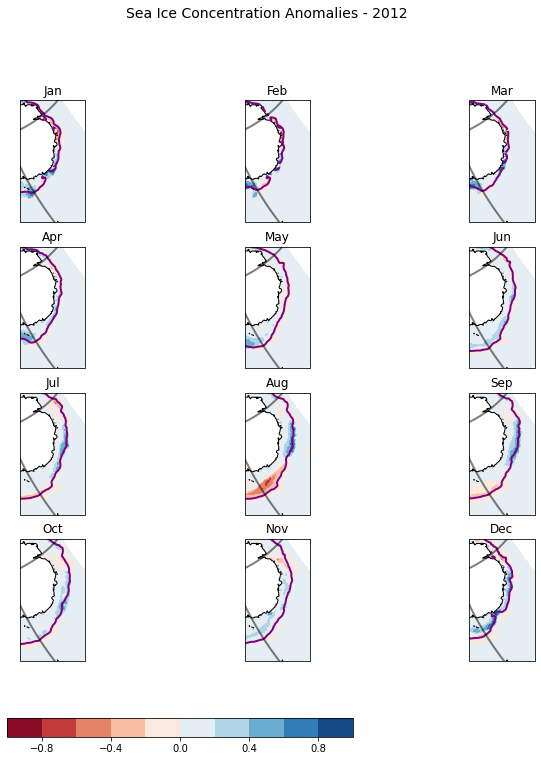

In [40]:
#very messy months in current year
months_in_current_year=ant_conc.anoms_da.where(ant_conc.anoms_da.time.dt.year==YEAR, drop=True).time.dt.month.values 

plt.figure(figsize=(12,13))
plt.suptitle('Sea Ice Concentration Anomalies - ' + str(YEAR), fontsize = 14)

for iMonth in months_in_current_year:
    
    ax = plt.subplot(5,3,iMonth,
        projection=ccrs.Stereographic()#central_longitude=(EAST_ANT_LONS[0]+EAST_ANT_LONS[1])/2)
        )
    
    ax.set_extent([EAST_ANT_LONS[0], EAST_ANT_LONS[1], -75, -55], crs=ccrs.PlateCarree())

    
    toPlot=ant_conc.conc_climat_ds.ave.sel(month=iMonth)
    
    plt.contour(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        levels=[.15],
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        colors='purple',
        linewidths=2
    )
    
    toPlot=ant_conc.anoms_da.sel(time=np.datetime64(str(YEAR)+"-"+"%02d" %iMonth))
    
    plt.contourf(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        levels=np.arange(-1,1.04,.2),
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='RdBu',
        )
    
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), xlocs=[EAST_ANT_LONS[0], EAST_ANT_LONS[1]], ylocs=[],
        draw_labels=False, linewidth=2, color='black', alpha=0.5, #linestyle='--'
    )

    ax.coastlines()
    plt.title(months[iMonth-1])

plt.subplots_adjust(hspace=0.2,wspace=0.02)
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.2,0.2,0.4,0.02]))
plt.show()

# Min / max extents in East Antarctica

In [41]:
min_extents=e_ant_conc.extent_da.groupby('time.year').min()
max_extents=e_ant_conc.extent_da.groupby('time.year').max()

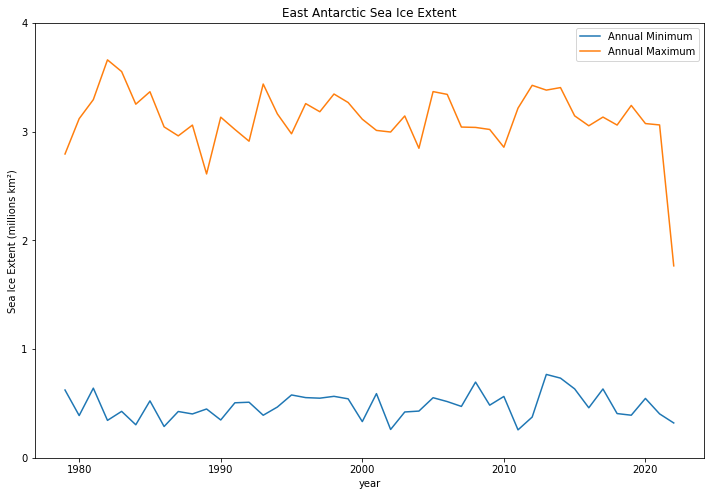

In [42]:
plt.figure(figsize=(12,8))

min_extents[1:].plot(label='Annual Minimum') #don't plot the first year (partial)
max_extents[1:].plot(label='Annual Maximum') 

plt.yticks(
    ticks=[0, 1e6, 2e6, 3e6, 4e6],
    labels=['0','1','2','3','4']
)

plt.title('East Antarctic Sea Ice Extent')
plt.ylabel('Sea Ice Extent (millions km\u00b2)')
plt.legend()

plt.show()

This figure is probably not interesting. There is no trend (well established elsewhere) and variability capture in climatology by month.

# And using the Uni Bremen ARTIST Data

This section is to show we can do it - this dataset only starts in 2012, so we are probably mostly interested in current conditions

In [43]:
artist_monthly_xr=xr.open_dataset(f'{_data_dir}/processed/asi2_monthly.nc', chunks='auto') # This file is the output from running processing.artist_aggregator

In [44]:
artist_areas_xr=xr.open_dataarray(f'{_data_dir}/Bremen/PolStereo_GridCellArea_s6.25km_Antarctic.nc')

In [45]:
artist_monthly_xr

<xarray.Dataset>
Dimensions:  (time: 119, y: 1328, x: 1264)
Coordinates:
  * time     (time) datetime64[ns] 2012-07-31 2012-08-31 ... 2022-05-31
  * y        (y) float64 -3.947e+06 -3.941e+06 ... 4.341e+06 4.347e+06
  * x        (x) float64 -3.947e+06 -3.941e+06 ... 3.941e+06 3.947e+06
Data variables:
    conc     (time, y, x) float32 dask.array<chunksize=(77, 664, 632), meta=np.ndarray>
Attributes:
    author:       University of Bremen, Gunnar Spreen [gunnar.spreen@uni-brem...
    Conventions:  CF-1.5
    GMT_version:  5.2.1 (r15220) [64-bit] [MP]
    history:      Mon Jan 21 19:51:26 2019: GDAL CreateCopy( /ssmi/www/htdocs...
    info:         AMSR2 sea ice concentration based on the ASI algorithm (Spr...
    title:        Produced by grdmath
    GDAL:         GDAL 2.1.3, released 2017/20/01

# East Antartic High Res Sea Ice Concentration

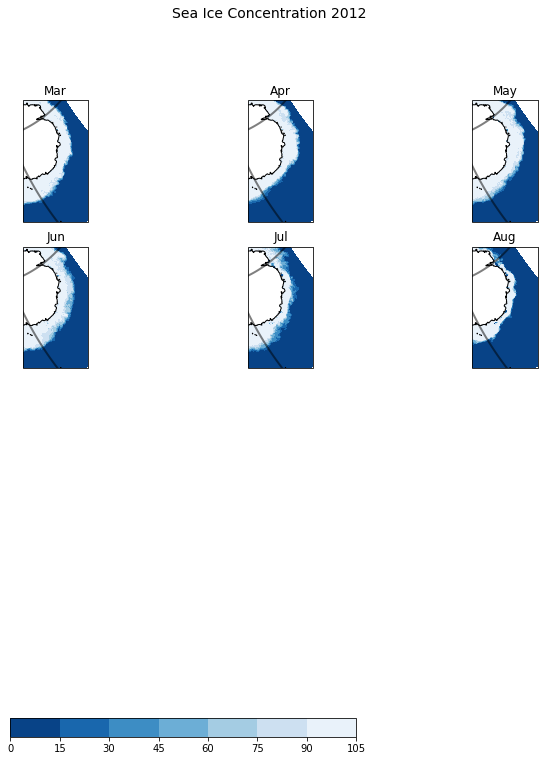

In [46]:
months_in_current_year=artist_monthly_xr.time.sel(time=slice(str(YEAR),str(YEAR)))

plt.figure(figsize=(12,13))
plt.suptitle('Sea Ice Concentration ' + str(YEAR), fontsize = 14)

i=0

for iMonth in months_in_current_year:
    i+=1
    ax = plt.subplot(5,3,i,
        projection=ccrs.Stereographic()#central_longitude=(EAST_ANT_LONS[0]+EAST_ANT_LONS[1])/2)
        )
    
    ax.set_extent([EAST_ANT_LONS[0], EAST_ANT_LONS[1], -75, -55], crs=ccrs.PlateCarree())

    toPlot=artist_monthly_xr.sel(time=iMonth).conc
    
    plt.contourf(
        toPlot.x, 
        toPlot.y, 
        toPlot,
        #levels=[0.2,0.4,0.6,0.8,0.9,1.00],
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='Blues_r',
        )
    
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), xlocs=[EAST_ANT_LONS[0], EAST_ANT_LONS[1]], ylocs=[],
        draw_labels=False, linewidth=2, color='black', alpha=0.5, #linestyle='--'
    )

    ax.coastlines()
    plt.title(months[i+1])

plt.subplots_adjust(hspace=0.2,wspace=0.02)
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.2,0.2,0.4,0.02]))
plt.show()

In [47]:
artist_ant_conc=sea_ice_conc(
    artist_monthly_xr.conc, 
    artist_areas_xr, 
    climat_dates=[2012,2020],
    conc_range=[15,100]
)

In [48]:
artist_ant_conc.calc_gridded_anoms()

In [49]:
YEAR

2012

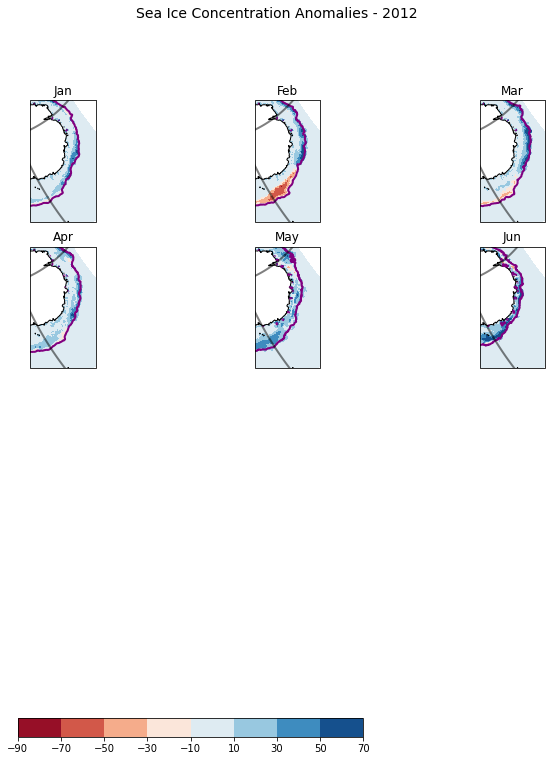

In [50]:
months_in_current_year=artist_monthly_xr.time.sel(time=slice(str(YEAR),str(YEAR))) #datetime obj for each month in the year we are plotting

plt.figure(figsize=(12,13))
plt.suptitle('Sea Ice Concentration Anomalies - ' + str(YEAR), fontsize = 14)

i=0 # a count of which month we are in
for iMonth in months_in_current_year:
    i+=1 
    ax = plt.subplot(
        5,3,i,
        projection=ccrs.Stereographic(
            #central_longitude=(EAST_ANT_LONS[0]+EAST_ANT_LONS[1])/2
            )
        )
    
    ax.set_extent([EAST_ANT_LONS[0], EAST_ANT_LONS[1], -75, -55], crs=ccrs.PlateCarree())

    #include a line for the sea ice extent
    toPlot=artist_ant_conc.conc_climat_ds.ave.sel(month=iMonth.dt.month.values)
    plt.contour(
        toPlot.x, 
        toPlot.y, 
        toPlot,
        levels=[15],
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        colors='purple',
        linewidths=2
    )

    
    toPlot=artist_ant_conc.anoms_da.sel(time=iMonth)
    plt.contourf(
        toPlot.x, 
        toPlot.y, 
        toPlot,
        levels=np.arange(-90,90,20),
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='RdBu',
        )
    
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), xlocs=[EAST_ANT_LONS[0], EAST_ANT_LONS[1]], ylocs=[],
        draw_labels=False, linewidth=2, color='black', alpha=0.5, #linestyle='--'
    )

    ax.coastlines()
    plt.title(months[i-1])

plt.subplots_adjust(hspace=0.2,wspace=0.02)
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.2,0.2,0.4,0.02]))
plt.show()

In [51]:
client.close()

In [52]:
print(client)


<Client: No scheduler connected>
